<h1>Lab : simplified JPEG encoder/decoder</h1>

**Read the guidance**

**Read the topic (.pdf file) first**

**Some given functions:** (in Section 2)
  - zigzag
  - functions related to Huffman coding, such as ``construct_huffman_table, encode_huffman, decode_huffman``

**Functions to be implemented:**
  - rlencode (in Section 1)
  - count_symbols (in Section 1)
  - and also the 'main' functions (in Section 3)

**Some useful functions:** 
  - imshow()
  - img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2GRAY)
  - cv2.dct

**You can directly go to Section 3 and code there**

**Import the libs**

In [75]:
import numpy as np  
import requests
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
from typing import List, Tuple, Any, Dict, Optional

import cv2

def show(img:np.ndarray):
    im = Image.fromarray(img)
    print(im.size, im.mode, im.format, img.min(),  img.max())
    display(im)

def load_from_url(url: str) -> np.ndarray:
    return np.asarray(Image.open(requests.get(url, stream=True).raw))

def debug_ndarray(arr:np.ndarray, name:str='') -> None:
    print(name, arr.shape, arr.dtype, arr.min(), arr.max())

def imshow(img):
    import cv2
    import IPython
    _,ret = cv2.imencode('.jpg', img) 
    i = IPython.display.Image(data=ret)
    IPython.display.display(i)


# 1. Functions to be implemented

*   rlencode: Run length coding
*   count_symbols: this will be used for Huffman coding
*   zigzag: optional (since there will be a quite easy 'manual' way for doing that)
*   **Note: however, you dont need to implement these functions immediately. You can go to Section 3 to implement different first steps of JPEG: block devivision, centering, DCT, quantification.** 





In [76]:
def zigzag(matrix: np.ndarray) -> np.ndarray:
    """
    computes the zigzag of a quantized block
    :param numpy.ndarray matrix: quantized matrix
    :returns: zigzag vectors in an array
    """
    # initializing the variables
    h = 0
    v = 0
    v_min = 0
    h_min = 0
    v_max = matrix.shape[0]
    h_max = matrix.shape[1]
    i = 0
    output = np.zeros((v_max * h_max))

    while (v < v_max) and (h < h_max):
        if ((h + v) % 2) == 0:  # going up
            if v == v_min:
                output[i] = matrix[v, h]  # first line
                if h == h_max:
                    v = v + 1
                else:
                    h = h + 1
                i = i + 1
            elif (h == h_max - 1) and (v < v_max):  # last column
                output[i] = matrix[v, h]
                v = v + 1
                i = i + 1
            elif (v > v_min) and (h < h_max - 1):  # all other cases
                output[i] = matrix[v, h]
                v = v - 1
                h = h + 1
                i = i + 1
        else:  # going down
            if (v == v_max - 1) and (h <= h_max - 1):  # last line
                output[i] = matrix[v, h]
                h = h + 1
                i = i + 1
            elif h == h_min:  # first column
                output[i] = matrix[v, h]
                if v == v_max - 1:
                    h = h + 1
                else:
                    v = v + 1
                i = i + 1
            elif (v < v_max - 1) and (h > h_min):  # all other cases
                output[i] = matrix[v, h]
                v = v + 1
                h = h - 1
                i = i + 1
        if (v == v_max - 1) and (h == h_max - 1):  # bottom right element
            output[i] = matrix[v, h]
            break
    return output
    

def rlencode(data:list, symbol:int=0, escape=257) -> np.ndarray:
    '''
    Encode a list of values using run length encoding
    when `symbol` is encountered, 
    the next value is `escape` followed by the number of `symbol`.
    '''
    
    out=[]
    count=0
    for i in data:
        if i==symbol:
            count+=1
        else:
            if count>0:
                out.append(escape)
                out.append(count)
                count=0
            out.append(i)
            
    if count>0:
        out.append(escape)
        out.append(count)
        
    return np.array(out)

test=rlencode([0, 0, 0, 0, 1, 1, 1, 2, 2, 3, 0, 0, 0], 0, 257)
print(test)
    

def count_symbols(data:list) -> Dict[Any, int]:
    '''
    Compute the frequency of each value in the list
    '''
    freq = {}
    for i in data:
        if i in freq:
            # increment count of word by 1
            freq[i] += 1
        else:
            # add the word to dictionary with count 1
            freq[i] = 1
    return freq

    
#testing
freq = count_symbols([0, 0, 0, 0, 1, 1, 1, 2, 2, 3])
print(freq)
#'output: {0: 4, 1: 3, 2: 2, 3: 1}'


[257   4   1   1   1   2   2   3 257   3]
{0: 4, 1: 3, 2: 2, 3: 1}


#2. Given functions

**Huffman tree**

To obtain the Huffman code, it is necessary to construct a (binary) Huffman tree.
This tree is constructed from a list of leaves (symbols) and internal nodes (sum of the weights of the children).
Each node is associated with a value which is the sum of the values of its children.
The leaves correspond to symbols and are associated with their number of occurrences in the vector.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/82/Huffman_tree_2.svg/1200px-Huffman_tree_2.svg.png" width=500>

Huffman encoding involves counting the number of occurrences of each character in a sentence and representing each character as a leaf node on a tree with a weight equal to its occurrence count. The tree is constructed by combining the two nodes with the lowest weights at each step until only one node, the root of the tree, remains.

In [77]:
def compute_huffman_tree(data:list, freq:Optional[dict]=None) -> Tuple[int, Any, Any]:
    '''
    Compute a huffman tree from a frequency table of values
    Return the root node of the tree
    '''
    if freq is None:
        freq: Dict[Any, int] = count_symbols(data)

    # create a list of nodes
    nodes = []
    for symbol, freq in freq.items():
        nodes.append((freq, symbol))
    
    # sort the list of nodes by count
    nodes.sort(key=lambda x: x[0])

    # create a tree
    while len(nodes) > 1:
        # get the two lowest frequency nodes
        left, right = nodes[:2]
        
        # create a new node with the sum of the frequencies
        new_node_count = left[0] + right[0]
        new_node = (new_node_count, left, right)
        # remove the two lowest frequency nodes
        nodes = nodes[2:]
        # insert the new node
        nodes.append(new_node)
        # sort the nodes by frequency
        nodes.sort(key=lambda x: x[0])

    # return the root node
    return nodes[0]

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)

from pprint import pprint

data_tree = compute_huffman_tree(data)
pprint(data_tree)

(36,
 (16,
  (8, (4, 'a'), (4, 'e')),
  (8, (4, (2, 't'), (2, 'h')), (4, (2, 'i'), (2, 's')))),
 (20,
  (8,
   (4, (2, 'n'), (2, 'm')),
   (4, (2, (1, 'x'), (1, 'p')), (2, (1, 'l'), (1, 'o')))),
  (12, (5, (2, (1, 'u'), (1, 'r')), (3, 'f')), (7, ' '))))


**Huffman coding table**

Read and test the following functions

In [78]:
def display_table(lines, code:dict, sep='\t'):
    '''
    Display a table of data with columns aligned
    '''
    cols_width = [max(len(str(x)) for x in col) for col in zip(*lines)]
    for line in lines:
        # adjust each column to its max width
        print(*[x.rjust(w) for x, w in zip(line, cols_width)], sep=sep)

def display_huffman_table(data, code:dict, sep='\t'):
    counts: dict = count_symbols(data)
    total = sum(counts.values())
    lines = [('Symbol', 'Code', 'Count', 'Frequency')]
    tmp = sorted(list(counts.keys()), key=lambda x: counts[x], reverse=True)
    for k in tmp:
        symbol = f"`{k}`"
        symbol_code = str(counts[k])
        count = str(code[k])
        freq = str(round(100 * counts[k] / total, 2))+'%'
        lines.append((symbol, symbol_code, count, freq))
    display_table(lines, code, sep=sep)

def bintree_to_table(node, path=None, left='0', right='1') -> Dict[str, str]:
    '''
    Build a huffman table from a huffman tree
    Return a dictionary of symbol:code
    '''
    if path is None:
        path = ''
    table = {}
    if len(node) == 2: # leaf node
        count, symbol = node
        table[symbol] = path
    else: # internal node
        node_left, node_right = node[1], node[2]
        left_path = bintree_to_table(node_left, path + left, left=left, right=right)
        right_path = bintree_to_table(node_right, path + right, left=left, right=right)
        table.update(left_path)
        table.update(right_path)
    
    return table

sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
data_tree = compute_huffman_tree(data)
data_table = bintree_to_table(data_tree)

# display the huffman table
display_huffman_table(data, data_table)


Symbol	Code	Count	Frequency
   ` `	   7	  111	   19.44%
   `a`	   4	  000	   11.11%
   `e`	   4	  001	   11.11%
   `f`	   3	 1101	    8.33%
   `t`	   2	 0100	    5.56%
   `h`	   2	 0101	    5.56%
   `i`	   2	 0110	    5.56%
   `s`	   2	 0111	    5.56%
   `n`	   2	 1000	    5.56%
   `m`	   2	 1001	    5.56%
   `x`	   1	10100	    2.78%
   `p`	   1	10101	    2.78%
   `l`	   1	10110	    2.78%
   `o`	   1	10111	    2.78%
   `u`	   1	11000	    2.78%
   `r`	   1	11001	    2.78%


***Take time to test the three following functions, you will use them for Huffman codage/decodage***

In [79]:
def construct_huffman_table(data:list) -> dict:
    '''
    Encode a list of values using huffman encoding and return the huffman table
    '''
    counts = count_symbols(data)
    tree = compute_huffman_tree(counts)
    table = bintree_to_table(tree)
    return table

def encode_huffman(data: list, table: dict) -> str:
    '''
    Encode a list of values using the huffman table dictionary
    Return the encoded string
    '''
    out = []
    for i in data:
        out.extend(table[i])
    out = ''.join(out) # list to string
    return out

def decode_huffman(encoded:str, table: dict) -> np.ndarray:
    '''
    Decode a list of values using huffman code dictionary
    '''
    data = []
    i = 0
    while i < len(encoded):
        for k, v in table.items():
            if encoded[i:].startswith(v): # prefix match
                data.append(k)
                i += len(v)
                break
    return np.array(data)

# testing
sentence = "this is an example of a huffman tree"
#convert sentence to list of characters
data = list(sentence)
table = construct_huffman_table(data)
print("Test 1")
print(table)

# Testing
print("Test 2")
data = [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
data_table = construct_huffman_table(data)
print('Original :', data)

encoded = encode_huffman(data, data_table)
print('Encoded  :', encoded)

decoded = decode_huffman(encoded, data_table)
print('Decoded  :', decoded)


Test 1
{'t': '0000', 'h': '0001', 'i': '0010', 's': '0011', ' ': '0100', 'a': '0101', 'n': '0110', 'e': '0111', 'x': '1000', 'm': '1001', 'p': '1010', 'l': '1011', 'o': '1100', 'f': '1101', 'u': '1110', 'r': '1111'}
Test 2
Original : [0, 1, 0, 0, 0, 0, 0, 2, 0, 4, 4, 2, 3]
Encoded  : 1101111101101101101100011001010010
Decoded  : [0 1 0 0 0 0 0 2 0 4 4 2 3]


#3. TODO: Codage/Decodage

In [80]:
# ZigZag example

# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])

lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])

rdMatrix = np.round(np.random.rand(8,8)*10)

out = np.zeros(64)
for k in range(64):
    out[k] = rdMatrix[lig[k]-1,col[k]-1] # -1 since indexes start from 0 in Python...

print(rdMatrix)
print(out)


[[ 3.  2.  8.  2.  9.  0.  9.  3.]
 [ 7.  8.  8.  7.  9.  0.  4.  4.]
 [ 6.  4.  2.  5.  3.  9.  9.  8.]
 [ 6.  8. 10.  3.  8.  5.  4. 10.]
 [ 6.  0.  8.  2.  6.  6.  1.  5.]
 [ 3.  2.  5.  2.  1.  9.  3.  7.]
 [ 0.  9.  6.  8. 10.  5.  4.  7.]
 [ 7.  8.  6.  5.  2.  6.  7.  8.]]
[ 3.  2.  7.  6.  8.  8.  2.  8.  4.  6.  6.  8.  2.  7.  9.  0.  9.  5.
 10.  0.  3.  0.  2.  8.  3.  3.  0.  9.  3.  4.  9.  8.  2.  5.  9.  7.
  8.  6.  2.  6.  5.  9.  4.  8.  4.  6.  1.  8.  6.  5. 10.  9.  1. 10.
  5.  3.  5.  2.  6.  4.  7.  7.  7.  8.]


(256, 256) RGB None 0 255


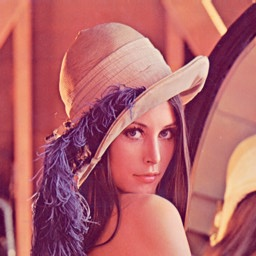

(256, 256) L None 48 255


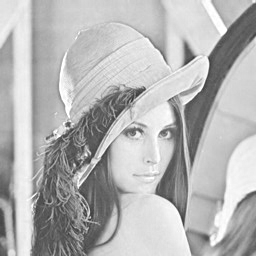

(256, 256) L None 0 235


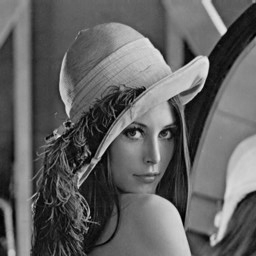

(256, 256) L None 17 225


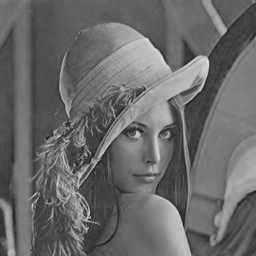

In [81]:
# define quantization tables
qY = np.array([[16, 11, 10, 16, 24, 40, 51, 61],  # luminance quantization table
                [12, 12, 14, 19, 26, 48, 60, 55],
                [14, 13, 16, 24, 40, 57, 69, 56],
                [14, 17, 22, 29, 51, 87, 80, 62],
                [18, 22, 37, 56, 68, 109, 103, 77],
                [24, 35, 55, 64, 81, 104, 113, 92],
                [49, 64, 78, 87, 103, 121, 120, 101],
                [72, 92, 95, 98, 112, 100, 103, 99]])

qC = np.array([[17, 18, 24, 47, 99, 99, 99, 99],  # chrominance quantization table
                [18, 21, 26, 66, 99, 99, 99, 99],
                [24, 26, 56, 99, 99, 99, 99, 99],
                [47, 66, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99],
                [99, 99, 99, 99, 99, 99, 99, 99]])

# read an image and show it
url = "http://www.lenna.org/len_std.jpg"
imgOriginal = load_from_url(url)
show(imgOriginal)

img_array = np.array(imgOriginal)

#get red, green and blue channels

redC=img_array[:,:,0]
blueC=img_array[:,:,1]
greenC=img_array[:,:,2]

show(redC)
show(blueC)
show(greenC)






[[142 142 143 ... 146 148 123]
 [142 142 142 ... 158 158 122]
 [141 141 141 ... 141 134  99]
 ...
 [ 43  48  47 ...  71  78  81]
 [ 42  45  45 ...  79  83  82]
 [ 39  42  44 ...  87  91  91]]
(256, 256) L None 15 234


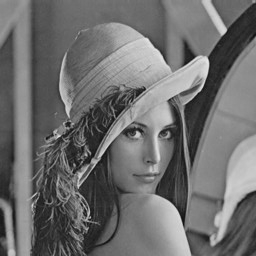

[[142 142 143 143 144 143 141 138]
 [142 142 142 143 143 141 138 137]
 [141 141 141 140 140 139 137 134]
 [139 139 139 139 139 138 135 134]
 [136 136 136 136 137 137 136 134]
 [135 135 135 135 136 135 135 134]
 [135 134 134 134 134 134 134 133]
 [135 135 134 134 134 134 133 132]]
[[138 138 136 135 136 135 134 135]
 [135 137 135 134 135 134 133 135]
 [134 135 134 132 134 134 133 135]
 [132 134 132 131 133 132 132 134]
 [133 135 132 131 132 131 129 132]
 [134 135 132 131 133 131 130 132]
 [134 135 133 132 133 132 131 134]
 [133 135 133 132 134 133 132 134]]
[[136 137 140 142 146 148 151 153]
 [134 137 140 142 145 148 151 152]
 [133 136 139 142 145 148 150 151]
 [132 135 138 142 145 148 150 151]
 [131 135 138 143 146 148 150 151]
 [133 135 140 144 147 148 149 149]
 [136 138 142 146 147 147 147 146]
 [138 141 144 147 147 146 145 144]]
[[152 148 145 141 135 126 110  94]
 [152 149 145 140 132 123 109  94]
 [151 149 144 138 129 120 107  93]
 [151 148 144 136 125 116 104  92]
 [149 146 142 134

IndexError: list index out of range

In [93]:
# For students
# TODO: Write your 'main' code 
# convert color image into gray image (or image in YCrCb space)

# This is just an example of coding, you can make your code differently

# ADVICE: create an other 'Code cell' and write/test your code gradually there 
# since the code given here is not exectable yet 

img = cv2.cvtColor(imgOriginal, cv2.COLOR_BGR2YCrCb)
# color
# First, you can work with only gray images for simplicity


width = len(img[0])
height = len(img)

# 
img_gray = img[:, :, 0]
print(img_gray)
#

#show img_gray
show(img_gray)

# define block size
blockSize = 8

# compute number of blocks
numBlocksH = int(height / blockSize)

# padding
if height % blockSize != 0:
    numBlocksH = numBlocksH + 1

# luminance channel (Y)
lumCh = img[:, :, 0]



# for color images we can work with the YCrCb space
# chrominance channels should be sub-sampled with different sub-sampling factors
# A very simple way: using a 2x2 averaging filter 
# another type of filter can be used
# then we can work with the sub-sampled version of the chrominance channels
#--------------------

# define empty matrices to store Dct
imgDct=np.zeros((height, width), np.float32)

# define empty matrices to store the quantized values
imgQuant=np.zeros((height, width), np.float32)


# This will be used for of ZigZag...
col = np.array([1, 2, 1, 1, 2, 3, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5,
                6, 7, 8, 7, 6, 5, 4, 3, 2, 1, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 6, 7, 8, 8, 7, 8])


lig = np.array([1, 1, 2, 3, 2, 1, 1, 2, 3, 4, 5, 4, 3, 2, 1, 1, 2, 3, 4, 5, 6, 7, 6, 5, 4, 3, 2, 1, 1, 2,
                3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 3, 2, 3, 4, 5, 6, 7, 8, 8, 7, 6, 5, 4, 5, 6, 7, 8, 8, 7, 6, 7, 8, 8])


ZZ_Blk = np.zeros(blockSize * blockSize) #1D

vRLC = [] #1D

size_vRLC = 0


#pseudo-code
for i in range(numBlocksH): #of course, this needs to be computed
    for j in range(numBlocksH):
        # get the block
        block=img_gray[i*blockSize:(i+1)*blockSize, j*blockSize:(j+1)*blockSize]
        print(block)

        # DCT
        imgDct = cv2.dct(block.astype(np.float32))
        
        
        # Quantization
        imgQuant= np.round(imgDct / qY)
        # easy ZigZag Version 2: 
        # use the `col` and `lig` vectors
        # and the `ZZ_Blk` vector
        ZZ_Blk= imgQuant[lig-1, col-1]
      
        # zigzag (1D)
        
        
        

        
        
        # run length coding (1D)
        # can use `extend` function of numpy vRLC.extend()

#end for


# Huffman
mat_table: dict = construct_huffman_table(vRLC)
mat_encoded: str = encode_huffman(vRLC, mat_table)

In [ ]:
# For testing a block, all steps (notably zigzag, rlc) are OK


**Compute compression rates at different stages**

In [89]:
# number of bits in original image
H, W, C = img.shape


print(size_yRLC)

NameError: name 'size_yRLC' is not defined

**Decodage**

In [ ]:
# Huffman decoding
decoded = decode_huffman(mat_encoded, mat_table)
print(len(decoded))

SyntaxError: invalid syntax (1963406596.py, line 2)

In [ ]:
print(decoded)

In [ ]:
decoded - yRLC